In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # plotting library

# Kaggle specific
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [44]:
"""
# We read in the data and do some feature engineering and
# also some exploratory data analysis
"""
train_data_df = pd.read_csv('./data/train.csv', index_col=False)

# Confirm the shape of our dataset is correct
train_data_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [45]:
"""
# We'll now engineer a new feature called desk (which gets the deck of each cabin)
# First covert the ['Cabin'] features to string and the match to a deck
"""
train_data_df['Cabin'] = train_data_df['Cabin'].astype(pd.StringDtype()).astype(str)

decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

def match_cabin_to_deck(cabin: str, decks):
    for substr in decks:
        if cabin.find('<NA>') != -1:
            return 'UNKNOWN'
        elif cabin.find(substr) != -1:
            return substr
    return np.nan

train_data_df['Deck'] = train_data_df['Cabin'].map(lambda x: match_cabin_to_deck(x, decks))

In [46]:
train_data_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,<NA>,S,UNKNOWN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,<NA>,S,UNKNOWN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,<NA>,S,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,<NA>,S,UNKNOWN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,<NA>,S,UNKNOWN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


In [47]:
train_data_df = train_data_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Deck', 'Survived']]
train_data_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Deck,Survived
0,3,male,22.0,1,0,7.2500,<NA>,S,UNKNOWN,0
1,1,female,38.0,1,0,71.2833,C85,C,C,1
2,3,female,26.0,0,0,7.9250,<NA>,S,UNKNOWN,1
3,1,female,35.0,1,0,53.1000,C123,S,C,1
4,3,male,35.0,0,0,8.0500,<NA>,S,UNKNOWN,0
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,<NA>,S,UNKNOWN,0
887,1,female,19.0,0,0,30.0000,B42,S,B,1
888,3,female,NaN,1,2,23.4500,<NA>,S,UNKNOWN,0
889,1,male,26.0,0,0,30.0000,C148,C,C,1


In [120]:
X = train_data_df.iloc[:, 0:8]
y = train_data_df.iloc[:, -1]

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn.experimental.enable_iterative_imputer
from sklearn.impute import IterativeImputer

features = OrdinalEncoder(handle_missing='return_nan').fit_transform(X)
features = IterativeImputer().fit_transform(features)
features = pd.DataFrame(features, columns=X.columns)

transformed_df = pd.DataFrame(features, columns=X.columns)
transformed_df['Survived'] = y

transformed_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3.0,1.0,22.000000,1.0,0.0,7.2500,1.0,1.0,0
1,1.0,2.0,38.000000,1.0,0.0,71.2833,2.0,2.0,1
2,3.0,2.0,26.000000,0.0,0.0,7.9250,1.0,1.0,1
3,1.0,2.0,35.000000,1.0,0.0,53.1000,3.0,1.0,1
4,3.0,1.0,35.000000,0.0,0.0,8.0500,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...
886,2.0,1.0,27.000000,0.0,0.0,13.0000,1.0,1.0,0
887,1.0,2.0,19.000000,0.0,0.0,30.0000,147.0,1.0,1
888,3.0,2.0,19.831782,1.0,2.0,23.4500,1.0,1.0,0
889,1.0,1.0,26.000000,0.0,0.0,30.0000,148.0,2.0,1


In [121]:
transformed_df.corr(method='pearson')

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
Pclass,1.000000,-0.131900,-0.403472,0.083081,0.018443,-0.549500,-0.623554,0.043385,-0.338481
Sex,-0.131900,1.000000,-0.113440,0.114631,0.245489,0.182333,0.082104,0.118630,0.543351
Age,-0.403472,-0.113440,1.000000,-0.381355,-0.221497,0.091790,0.246873,-0.023056,-0.052778
SibSp,0.083081,0.114631,-0.381355,1.000000,0.414838,0.159651,-0.058893,-0.060689,-0.035322
Parch,0.018443,0.245489,-0.221497,0.414838,1.000000,0.216225,-0.003678,-0.079398,0.081629
Fare,-0.549500,0.182333,0.091790,0.159651,0.216225,1.000000,0.397105,0.063597,0.257307
Cabin,-0.623554,0.082104,0.246873,-0.058893,-0.003678,0.397105,1.000000,0.017583,0.270495
Embarked,0.043385,0.118630,-0.023056,-0.060689,-0.079398,0.063597,0.017583,1.000000,0.108736
Survived,-0.338481,0.543351,-0.052778,-0.035322,0.081629,0.257307,0.270495,0.108736,1.000000


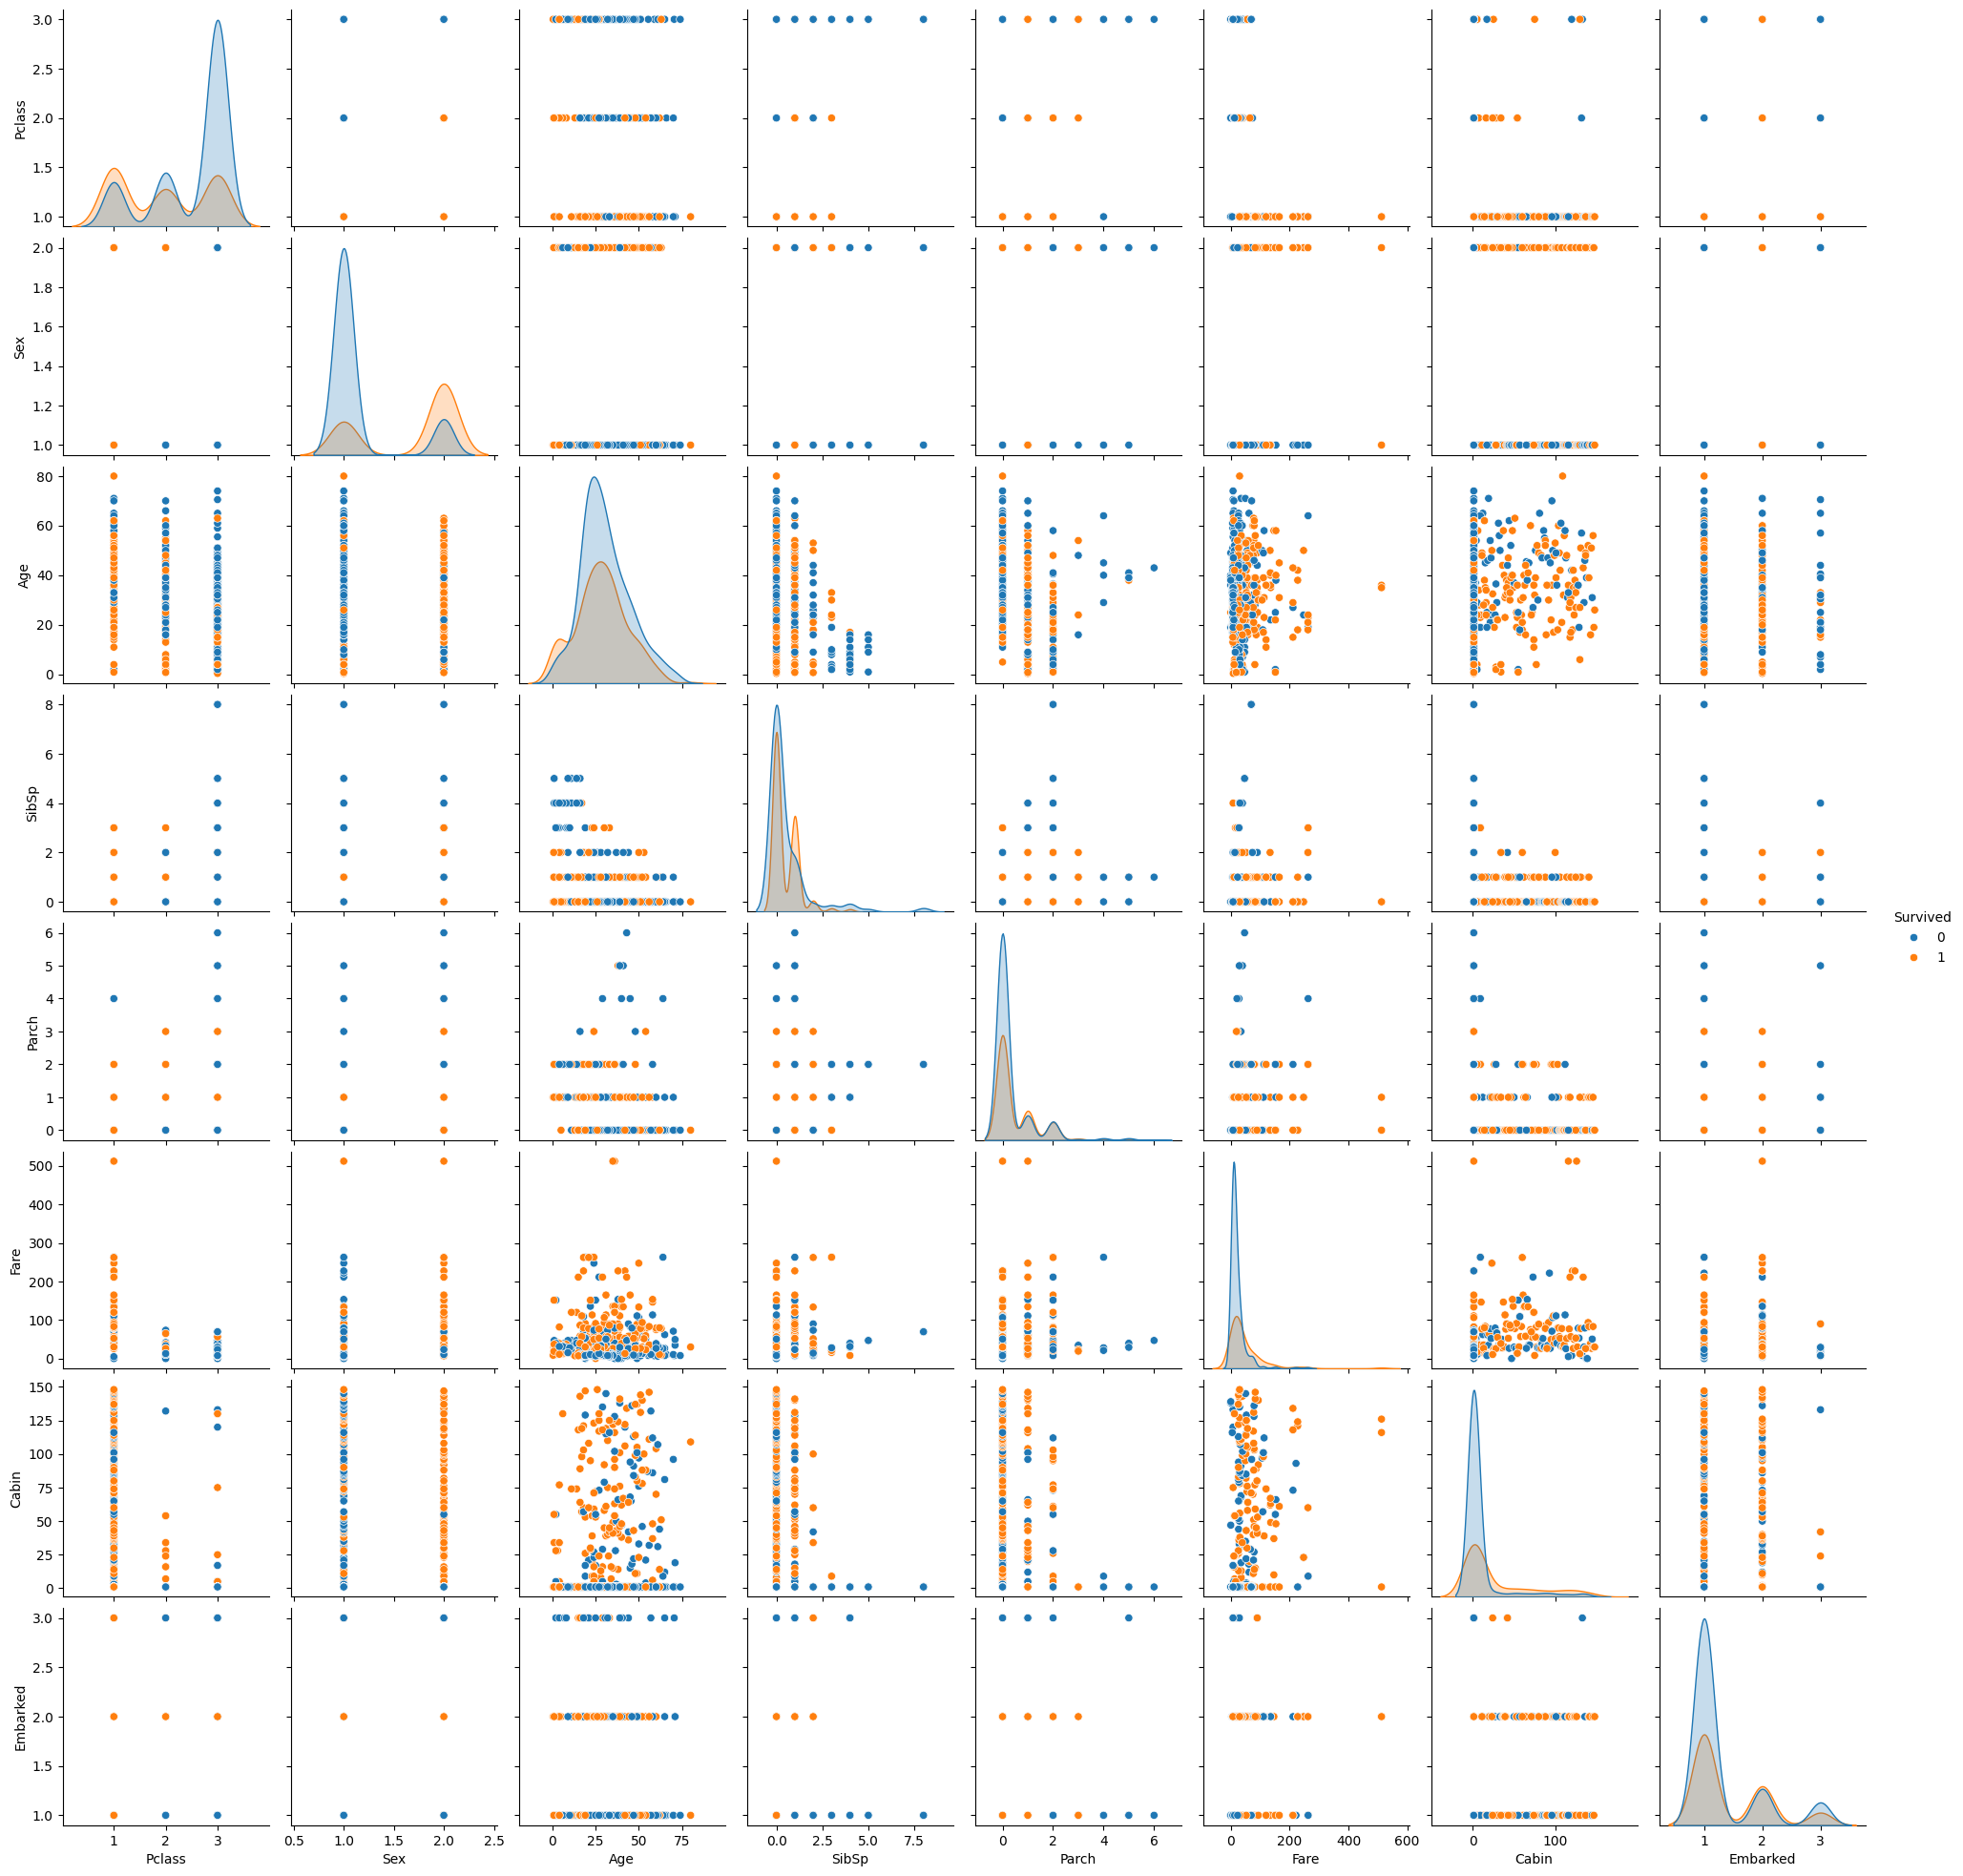

In [57]:
sns.pairplot(data=transformed_df, hue='Survived', palette='tab10')

In [122]:
filtered_df = transformed_df[['Age', 'Fare', 'Cabin', 'Sex', 'Embarked', 'Survived']]

In [127]:
"""
# Next, let's select the features that will make our predictions easier
# So far [Pclass, Age, Sex, Fare] seems like good features to 
# determine the likelihood of survival
"""
new_train_df = filtered_df

"""
# From the data we see here - after engineering a new feature 'deck',
# we see that regardless of whether the deck were known or unknown
# there is a huge rate of survival of female passengers
"""
# Confirm shape of our dataframe
new_train_df.shape

(891, 6)

In [151]:
"""
# Next, we import the test data and do the same feature engineering
# and data analysis as the training data
"""
test_data_df = pd.read_csv('./data/test.csv', index_col=False)
test_data_df = test_data_df[['PassengerId', 'Age', 'Fare', 'Cabin', 'Sex', 'Embarked']]

# Confirm the shape of our dataset is correct
test_data_df.shape

(418, 6)

In [152]:
# Confirm the shape of our dataset is correct
new_test_df = OrdinalEncoder(handle_missing='return_nan').fit_transform(test_data_df)
new_test_df = IterativeImputer().fit_transform(new_test_df)
new_test_df = pd.DataFrame(new_test_df, columns=test_data_df.columns)

# Confirm the shape of our test dataset and training dataset
new_train_df.shape, new_test_df.shape

((891, 6), (418, 6))

In [153]:
"""
# We will now prepare our datasets for our classifier
# using `sklearn` and more
"""
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import torch

In [157]:
# Split train data into X(features) and y(labels)
X_train = new_train_df.iloc[:, 0:5]
y_train = new_train_df.iloc[:, -1]

# Get test data X(features)
X_test = new_test_df.iloc[:, 1:6]

In [158]:
"""
# Next, we convert our dataframes to Tensor using PyTorch
"""
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values)

X_test = torch.Tensor(X_test.values)

In [ ]:
"""
# Next, we instantiate our model and train it on 
# our training data (tensor)
"""
# K-Neighbors Classifier & Tuning Parameters
N = 36
knn_clf = KNeighborsClassifier(n_neighbors=N, weights="distance", algorithm="kd_tree", leaf_size=30)

# Logistic Regression
log_clf = LogisticRegression(solver='liblinear', random_state=1)

# Random Forest Classifier
rand_forest_clf = RandomForestClassifier(
    n_estimators=19, 
    max_depth=None, 
    min_samples_split=2, 
    max_leaf_nodes=36, 
    random_state=1
)

# AdaBoost Classifier
ada_boost_clf = AdaBoostClassifier(base_estimator=rand_forest_clf, n_estimators=35, learning_rate=1.0, random_state=1)

# Fit model with training data
knn_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
rand_forest_clf.fit(X_train, y_train)
ada_boost_clf.fit(X_train, y_train)

# KFold for cross validation scoring
cv = KFold(n_splits=36, random_state=1, shuffle=True)
repeated_cv = RepeatedKFold(n_splits=5, n_repeats=N, random_state=1)

# KNN Scoring and Accuracy
scoring = knn_clf.score(X_train, y_train)
accuracy = cross_val_score(knn_clf, X_train, y_train, cv=repeated_cv, scoring='accuracy', n_jobs=-1).mean()

# LogRes Scoring & Accuracy
log_scoring = log_clf.score(X_train, y_train)
log_accuracy = cross_val_score(log_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()

# Random Forest Scoring & Accuracy
rand_forest_scoring = rand_forest_clf.score(X_train, y_train)
rand_forest_accuracy = cross_val_score(rand_forest_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()

# AdaBoost Scoring & Accuracy
ada_boost_scoring = ada_boost_clf.score(X_train, y_train)
ada_boost_accuracy = cross_val_score(ada_boost_clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()

In [160]:
print(f"KNN -> Score: {scoring}, Accuracy: {accuracy}")
print(f"Logistic Regression -> Score: {log_scoring}, Accuracy: {log_accuracy}")
print(f"Random Forest -> Score: {rand_forest_scoring}, Accuracy: {rand_forest_accuracy}")
print(f"Ada Boost -> Score: {ada_boost_scoring}, Accuracy: {ada_boost_accuracy}")

KNN -> Score: 0.9854096520763187, Accuracy: 0.7303653254660725
Logistic Regression -> Score: 0.7845117845117845, Accuracy: 0.7848148148148149
Random Forest -> Score: 0.8799102132435466, Accuracy: 0.8063425925925926
Ada Boost -> Score: 0.9854096520763187, Accuracy: 0.7725462962962963


In [166]:
"""
# Make prediction using test data
"""
y_pred = knn_clf.predict(X_test)
log_y_pred = log_clf.predict(X_test)
rand_forest_pred = rand_forest_clf.predict(X_test)
ada_boost_pred = ada_boost_clf.predict(X_test)

# Create new dataframe with PassengerId, y_pred as Survived
output = pd.DataFrame(
    {
        'PassengerId': test_data_df['PassengerId'],
        'Survived': pd.Series(y_pred, dtype=int)
    }
)

# output.to_csv('submission.csv', index=False)